In [2]:
import os 

import torch 
import torch.nn as nn
import numpy as np 

import torchvision 
from torchvision import models , datasets , transforms
from torch.nn import functional as F
from torch.utils.data import Dataset
from PIL import Image 

#matplotlib for visualization 
import matplotlib.pyplot as plt


In [3]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.0.1+cu117
cuda


In [7]:
class HumanSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'Training_Images')
        self.mask_dir = os.path.join(root_dir, 'Ground_Truth')
        self.transform = transform
        self.target_transform = target_transform
        self.image_filenames = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        seed=torch.randint(0,500,(1,)).item()
        # Load image
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        
        # Load corresponding mask
        mask_filename = self.image_filenames[idx].replace('.jpg', '.png')  # Adjust to your mask naming convention
        mask_path = os.path.join(self.mask_dir, mask_filename)
        mask = Image.open(mask_path)
        
        # Apply transforms
        if self.transform:
            torch.manual_seed(seed)
            image = self.transform(image)
        if self.target_transform:
            torch.manual_seed(seed)
            mask = self.target_transform(mask)
        
        return image, mask


In [110]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.8),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # Random vertical flip
    #transforms.RandomRotation(degrees=30),   # Random rotation up to ±30 degrees
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # Random color jitter
    transforms.ToTensor()  # Convert image to tensor
])

# Preprocessing for masks with augmentations using PyTorch transforms
preprocess_label = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.8),  # Random horizontal flip (same as for image)
    transforms.RandomVerticalFlip(p=0.5),    # Random vertical flip (same as for image)
    #transforms.RandomRotation(degrees=30),  # Random rotation with NEAREST resampling
    transforms.ToTensor()  # Convert mask to tensor
    #transforms.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.0), torch.tensor(0.0)))  # Binarize mask
])

data = HumanSegmentationDataset(root_dir=os.path.join("","data/Human-Segmentation"),
                                        transform=preprocess,
                                        target_transform=preprocess_label
                                        )
# print("validation set is being downloaded...")
# VOC_dataset_test = datasets.VOCSegmentation(root=os.path.join("","data"),
#                                          year='2012',
#                                           image_set = 'val',download=True,
#                                           transform=preprocess,
#                                           target_transform=preprocess_label)



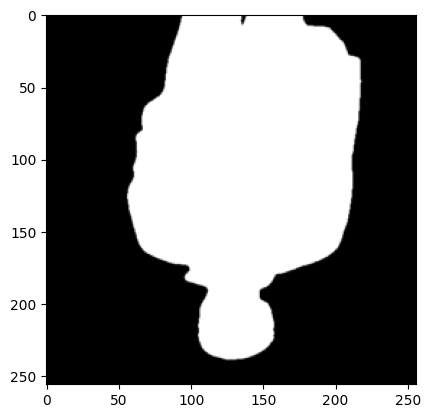

In [113]:
plt.imshow((data[50][1].squeeze()).numpy(),cmap='gray')


In [115]:
#parameters
BATCH_SIZE=4
size=len(data)
print(size)
VOC_dataset_training=torch.utils.data.Subset(data, range(int(0.95*size)))
VOC_dataset_test=torch.utils.data.Subset(data, range(int(0.95*size),size))
train_loader = torch.utils.data.DataLoader(VOC_dataset_training,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(VOC_dataset_test,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)


290


In [4]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [6]:
loss= DiceLoss()
pred = torch.tensor([[1, 1, 0], [0, 1, 1]], dtype=torch.float32, requires_grad=True)
target = torch.tensor([[1, 0, 0], [1, 1, 1]], dtype=torch.float32)
res=loss(pred,target)
print(res.item())

0.2222222089767456


Model architecture

In [23]:
class conv_block(nn.Module):
    """
    Convolutional downsampling block 
    Returns:
        Next layer and skip_connection outouts
    """
    def __init__(self,in_channels,n_filters=32,dropout_prob=0,max_pooling=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=in_channels, out_channels=n_filters, kernel_size=3, padding='same'),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=3, padding='same'),
            nn.BatchNorm2d(n_filters),
            nn.ReLU()
        ]
        
        if dropout_prob > 0:
            layers.append(nn.Dropout(p=dropout_prob))
        
        self.downsample = nn.Sequential(*layers)
        self.max_pooling = max_pooling
        if max_pooling:
            self.pool = nn.MaxPool2d(kernel_size=(2, 2))
    
    def forward(self, x):
        conv = self.downsample(x)
        skip_connection = conv  
        
        if self.max_pooling:
            next_layer = self.pool(conv)
        else:
            next_layer = conv  
        
        return next_layer, skip_connection
class upsampling_block(nn.Module):
    """
    convolutional upsampling block
    
    """
    def __init__(self,in_channels,n_filters=32):
        super().__init__()
        self.upsample=nn.ConvTranspose2d(in_channels=in_channels,out_channels=n_filters,kernel_size=2,stride=(2,2),padding=0)
        self.conv=nn.Sequential(
        nn.Conv2d(in_channels=2*n_filters,out_channels=n_filters,kernel_size=3,padding='same'),
        nn.BatchNorm2d(n_filters),
        nn.ReLU(),
        nn.Conv2d(in_channels=n_filters,out_channels=n_filters,kernel_size=3,padding='same'),
        nn.BatchNorm2d(n_filters),
        nn.ReLU()
        )
    def forward(self,expansive_input,contractive_input):
        up=self.upsample(expansive_input)
        merge= torch.cat([up,contractive_input],dim=1)
        output=self.conv(merge)
        return output

class Unet(nn.Module):
    def __init__(self, input_size, n_filters, n_classes):
        super().__init__()
        
        # Contracting path
        self.contracting_blocks = nn.ModuleList([
            conv_block(input_size[0], n_filters=n_filters),
            conv_block(n_filters, n_filters=2 * n_filters),
            conv_block(2 * n_filters, n_filters=4 * n_filters),
            conv_block(4 * n_filters, n_filters=8 * n_filters, dropout_prob=0.3),
            conv_block(8 * n_filters, n_filters=16 * n_filters, dropout_prob=0.3, max_pooling=False)
        ])
        
        # Expanding path
        self.expanding_blocks = nn.ModuleList([
            upsampling_block(16 * n_filters, n_filters=8 * n_filters),
            upsampling_block(8 * n_filters, n_filters=4 * n_filters),
            upsampling_block(4 * n_filters, n_filters=2 * n_filters),
            upsampling_block(2 * n_filters, n_filters=n_filters)
        ])
        
        self.conv9 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding='same')
        self.conv10 = nn.Conv2d(n_filters, n_classes, kernel_size=1,padding='same')
        self.activation=nn.ReLU()

    def forward(self, x,target=None):
        contractive_outputs = []

        # Contracting path
        for block in self.contracting_blocks:
            x, x_res = block(x)
            contractive_outputs.append(x_res)
        
        # Expanding path
        for i, block in enumerate(self.expanding_blocks):
            x = block(x, contractive_outputs[-(i+2)])

        
        x = self.conv9(x)
        x=self.activation(x)
        x = self.conv10(x)
        probs = F.sigmoid(x)
        #x=self.activation(x)
        if target is None:
            loss=None
            
            return probs,loss
        else:
            loss=DiceLoss()(probs, target)
        return x, loss

In [12]:
N_FILTERS=32
model=Unet(input_size=(3,256,256),n_filters=N_FILTERS,n_classes=1).to(device)

In [13]:
import random
eval_iters=5
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        if split=='train':
            batches = list(train_loader)
        else:
            batches = list(test_loader)
        for k in range(eval_iters):
            
            # Randomly select a batch
            X,Y = random.choice(batches)
            X,Y=X.to(device),Y.to(device)
            X = X.to(torch.float32)
            Y = Y.to(torch.float32)
            #with torch.autocast(device_type=device,dtype=torch.bfloat16):
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [48]:
@torch.no_grad()
def visualize(x,y):
    model.eval()
    test_image=x.unsqueeze(dim=0).to(device)
    probs,loss=model(test_image)
    probs=probs.squeeze().cpu()
    segment=torch.where(probs > 0.5 , 1, 0)
    segment =segment.squeeze().cpu().numpy()
    #print(np.min(segment), np.max(segment)) 
    fig, axis = plt.subplots(1, 2, figsize=(8, 4))  # Adjust 'figsize' for layout

# Plot first segmentation result
    axis[0].imshow(segment, cmap='gray')
    axis[0].axis("off")  # Remove axes
    axis[0].set_title("prediction")  # Optional title

    # Plot second segmentation result
    axis[1].imshow(y.squeeze().cpu().numpy(), cmap='gray')
    axis[1].axis("off")  # Remove axes
    axis[1].set_title("ground truth")  # Optional title

    # Display the figure with both plots
    plt.tight_layout()  # Optional: improve spacing
    plt.show()


In [ ]:
for i in range (100):
    print(np.unique(VOC_dataset_train[i][1].numpy()))

In [ ]:
#hyperparameters
N_FILTERS=32
model=Unet(input_size=(3,512,512),n_filters=N_FILTERS,n_classes=1).to(device)
learning_rate=0.0001
epochs=5000
# model_path = os.path.join("",'/model_weights.pt')
model_path = os.path.join("",'model_weights.pt')
model.load_state_dict(torch.load(model_path))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
(image,mask) = next(iter(train_loader))
image,mask=image.to(device),mask.to(device)
for epoch in range(epochs):
    optimizer.zero_grad()
    logits, loss = model(image, mask.squeeze().long())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    if epoch%100==0 :
        print(f"The training loss is: {loss :.6f}  at epoch {epoch}")
        visualize()

torch.save(model.state_dict(), model_path)
#model.load_state_dict(torch.load(model_path))

epoch 0 is being executed.


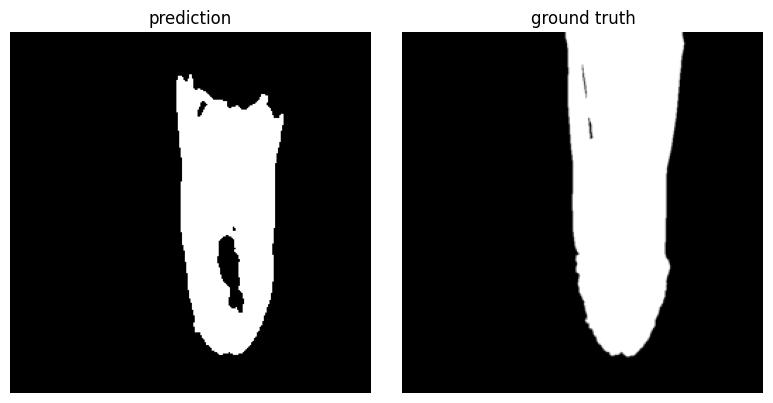

The training loss is: 0.160125 Validation loss is: 0.225707 at epoch 0
epoch 1 is being executed.
epoch 2 is being executed.
epoch 3 is being executed.
epoch 4 is being executed.
epoch 5 is being executed.


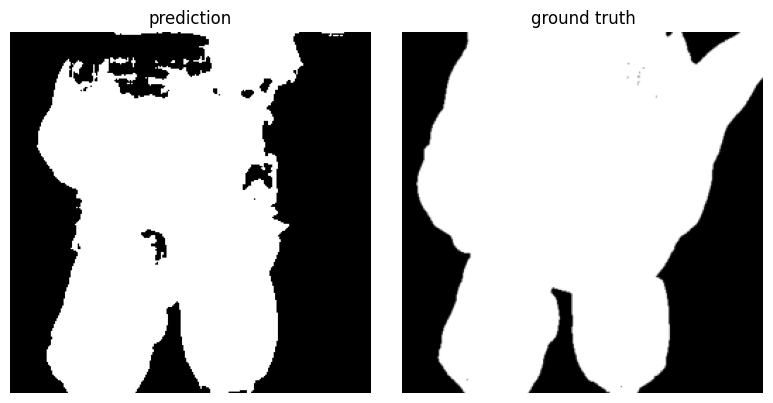

The training loss is: 0.077585 Validation loss is: 0.175325 at epoch 5
epoch 6 is being executed.
epoch 7 is being executed.
epoch 8 is being executed.
epoch 9 is being executed.
epoch 10 is being executed.


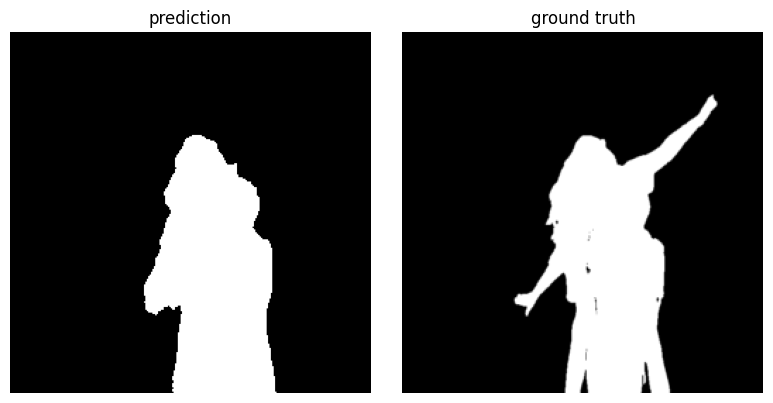

The training loss is: 0.035989 Validation loss is: 0.099540 at epoch 10
epoch 11 is being executed.
epoch 12 is being executed.
epoch 13 is being executed.
epoch 14 is being executed.
epoch 15 is being executed.


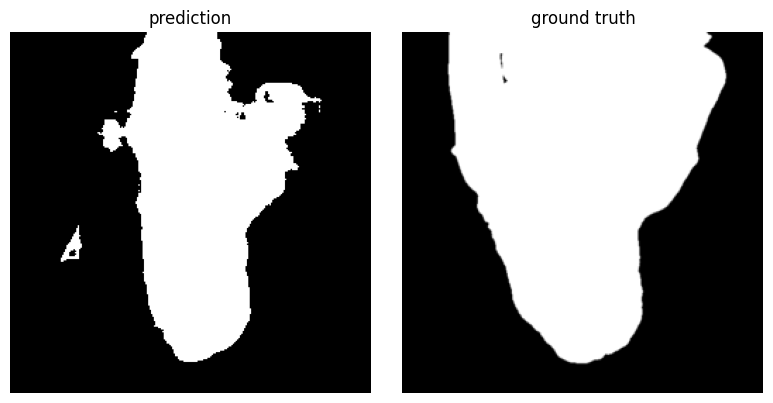

The training loss is: 0.030674 Validation loss is: 0.113481 at epoch 15
epoch 16 is being executed.
epoch 17 is being executed.
epoch 18 is being executed.
epoch 19 is being executed.
epoch 20 is being executed.


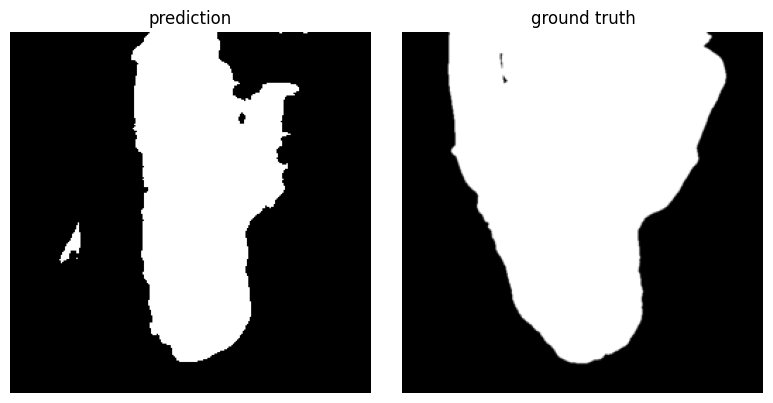

The training loss is: 0.026153 Validation loss is: 0.089596 at epoch 20
epoch 21 is being executed.
epoch 22 is being executed.
epoch 23 is being executed.
epoch 24 is being executed.
epoch 25 is being executed.


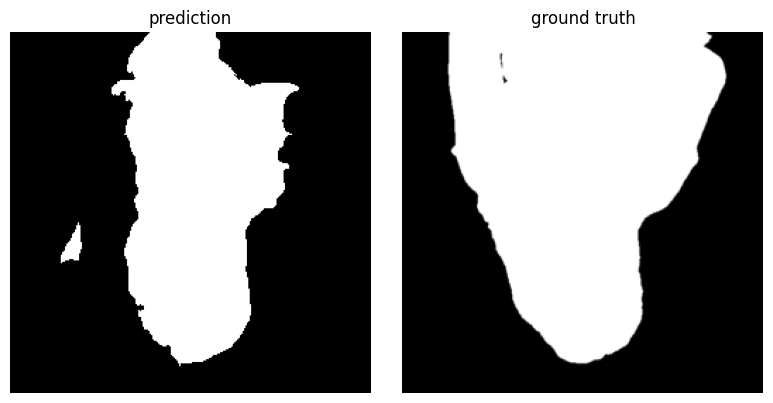

The training loss is: 0.032227 Validation loss is: 0.127113 at epoch 25
epoch 26 is being executed.
epoch 27 is being executed.
epoch 28 is being executed.
epoch 29 is being executed.
epoch 30 is being executed.


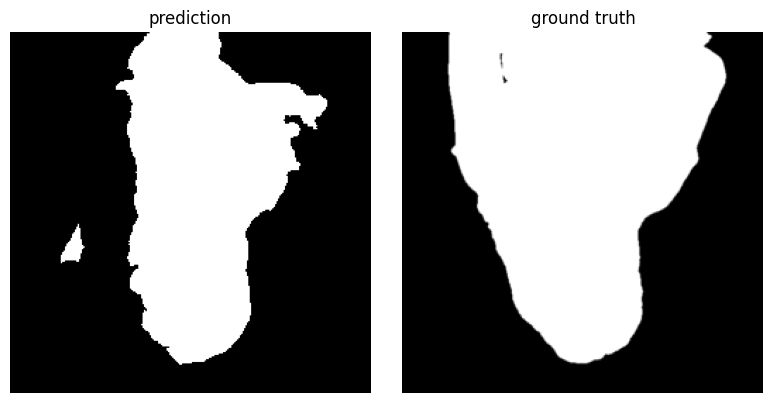

The training loss is: 0.024115 Validation loss is: 0.069465 at epoch 30
epoch 31 is being executed.
epoch 32 is being executed.
epoch 33 is being executed.
epoch 34 is being executed.
epoch 35 is being executed.


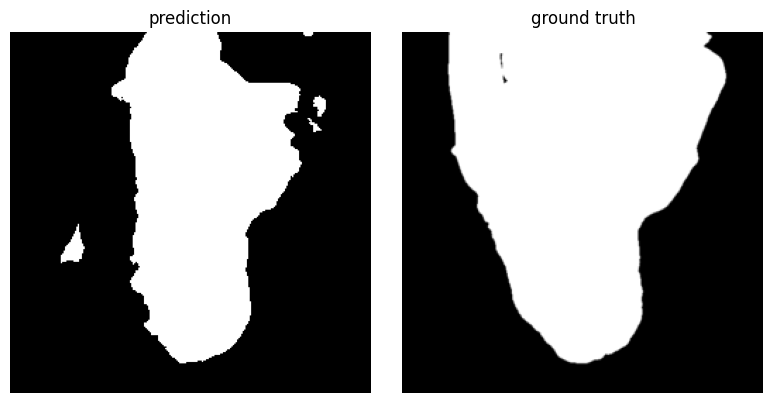

The training loss is: 0.009986 Validation loss is: 0.119266 at epoch 35
epoch 36 is being executed.
epoch 37 is being executed.
epoch 38 is being executed.
epoch 39 is being executed.
epoch 40 is being executed.


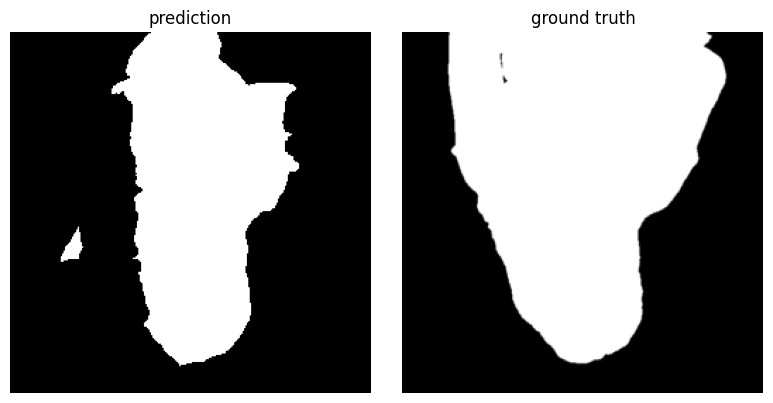

The training loss is: 0.023978 Validation loss is: 0.107459 at epoch 40
epoch 41 is being executed.
epoch 42 is being executed.
epoch 43 is being executed.
epoch 44 is being executed.
epoch 45 is being executed.


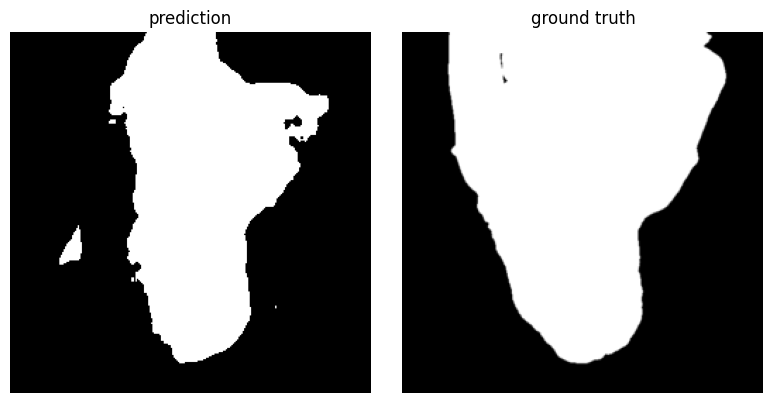

The training loss is: 0.022038 Validation loss is: 0.117923 at epoch 45
epoch 46 is being executed.
epoch 47 is being executed.
epoch 48 is being executed.
epoch 49 is being executed.


In [116]:
#hyperparameters

learning_rate=0.0001
epochs=50
N_FILTERS=32
model_path = os.path.join("",'model_weights_v4_dice.pt')

model=Unet(input_size=(3,256,256),n_filters=N_FILTERS,n_classes=1).to(device)
model.load_state_dict(torch.load(model_path))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=1e-5)
dataset = test_loader.dataset
for epoch in range(epochs):
    print(f"epoch {epoch} is being executed.")
    idx = torch.randint(0, len(dataset) - 1,(1,)).item()
    torch.manual_seed(idx)
    if epoch%5==0 :
            image,mask=dataset[idx]
            visualize(image,mask)
            losses = estimate_loss()
            print(f"The training loss is: {losses['train']:.6f} Validation loss is: {losses['val']:.6f} at epoch {epoch}")
            
    for batch,(image,mask) in enumerate(train_loader):
        optimizer.zero_grad()
        image,mask=image.to(device),mask.to(device)
        logits, loss = model(image, mask)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
model_path = os.path.join("",'model_weights_v4_dice.pt')
      
torch.save(model.state_dict(), model_path)
#model.load_state_dict(torch.load(model_path))



In [49]:
model_path = os.path.join("",'model_weights_ultimate.pt')
model.load_state_dict(torch.load(model_path))
#torch.save(model.state_dict(), model_path)

<All keys matched successfully>

In [ ]:
dataset = test_loader.dataset
for epoch in range(20):
    print(f"epoch {epoch} is being executed.")
    idx = torch.randint(0, len(dataset) - 1,(1,)).item()
    image,mask=dataset[idx]
    visualize(image,mask)

In [120]:
import cv2
import torchvision.transforms as T

model=Unet(input_size=(3,256,256),n_filters=N_FILTERS,n_classes=1).to(device)
model_path = os.path.join("",'model_weights_v4_dice.pt')
model.load_state_dict(torch.load(model_path))  # Replace with your U-Net loading
model.eval()

# Preprocessing transformations
preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 256)),  # Resize to input size of the model
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Post-processing for converting model output to mask
def decode_segmentation(mask, width, height):
    mask = mask.squeeze().cpu().numpy()
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    return mask == 1.0  # Adjust threshold as needed
def smooth_mask(mask):
    # Convert the mask to uint8 for OpenCV operations
    mask = mask.astype(np.uint8) * 255

    # Apply Gaussian blur to smooth edges
    mask = cv2.GaussianBlur(mask, (5, 5), 0)

    # Optionally, apply morphological operations to further smooth the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Closing small holes in the mask

    # Convert the mask back to boolean format
    mask = mask > 100  # Threshold to get back a binary mask
    return mask
# Function to blur background
def blur_background(frame, mask):
    #np.full_like(frame, [255, 255, 255])
    blurred_frame = cv2.GaussianBlur(frame, (25,25), cv2.BORDER_WRAP)
    mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)  # Convert mask to 3-channel
    result = np.where(mask_3d, frame, blurred_frame)  # Apply mask to keep person in focus
    return result

def replace_background(frame, mask, background_img):
    background_img = cv2.resize(background_img, (frame.shape[1], frame.shape[0]))  # Resize background to match frame
    mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)  # Convert mask to 3-channel
    result = np.where(mask_3d, frame, background_img)  # Apply mask to replace background
    return result

background_img = cv2.imread('background.jpg')
# Start video capture
cap = cv2.VideoCapture(0)  # 0 is the default webcam
if not cap.isOpened():
    print("Error: Could not open video capture.")
    exit()

try:
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break

        # Get frame dimensions
        height, width, _ = frame.shape

        # Preprocess the frame
        input_tensor = preprocess(frame).unsqueeze(0).to(device)

        # Perform segmentation (change this to U-Net forward pass)
        with torch.no_grad():
            output,loss = model(input_tensor)
            probs=output.squeeze()
            mask = torch.where(probs > 0.2 , 1, 0)

        # Decode the segmentation mask
        mask = decode_segmentation(mask, width, height)
        mask = smooth_mask(mask)
        # Blur the background
        output_frame = replace_background(frame, mask, background_img)

        # Display the resulting frame
        cv2.imshow('Human Segmentation with Background Blur', output_frame)

        # Exit when 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    # Ensure that video capture is released and all windows are closed
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
def compute_iou(prediction,ground_truth):
       # Calculate intersection and union
    intersection = torch.sum(prediction * ground_truth)
    union = torch.sum(prediction) + torch.sum(ground_truth) - intersection
    
    # Avoid division by zero
    if union == 0:
        return float('nan')  # Return NaN if both prediction and ground truth are empty
    
    # Compute IoU
    iou = intersection / union
    
    return iou.item()

In [130]:
VOC_dataset_debug = datasets.VOCSegmentation(root=os.path.join("","data"), 
                                        year='2012',
                                        image_set = 'train',download=True,
                                        transform=None,
                                        target_transform=None
                                          )

Using downloaded and verified file: data\VOCtrainval_11-May-2012.tar
Extracting data\VOCtrainval_11-May-2012.tar to data


In [64]:
model_path = os.path.join("",'model_weights.pt')
torch.save(model.state_dict(), model_path)

In [65]:
VOC_dataset_debug[2][1]

NameError: name 'VOC_dataset_debug' is not defined